In [2]:
#connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix


from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from distutils.dir_util import copy_tree, remove_tree

import os
print(os.listdir("/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02"))

print("TensorFlow Version:", tf.__version__)

['MODERATED DEMENTED', 'MILD DEMENTED', 'NON DEMENTED', 'VERY MILD DEMENTED']
TensorFlow Version: 2.12.0


In [5]:
input_file = '/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02'
output_file = '/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02 SPLITTED '

In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02 SPLITTED /train",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02 SPLITTED /test",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
"/content/drive/MyDrive/FINAL YEAR PROJECT/INPUT DATASET 02 SPLITTED /val",
seed=123,
image_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=64
)

Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.


In [7]:
class_names = train_ds.class_names
print(class_names)
train_ds

['MILD DEMENTED', 'MODERATED DEMENTED', 'NON DEMENTED', 'VERY MILD DEMENTED']


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.5 MB/s eta 0:00:00


In [9]:
model = keras.models.Sequential()
model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
model.add(keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))


model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation="relu",kernel_initializer="he_normal"))
model.add(keras.layers.Dense(64,"relu"))
model.add(keras.layers.Dense(4,"softmax"))

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy"])

In [11]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))

    # Tune the number of filters and kernel size for the first convolutional layer
    model.add(keras.layers.Conv2D(filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
                                  kernel_size=hp.Choice('conv1_kernel', values=[3,5]),
                                  padding='same', activation='relu', kernel_initializer="he_normal"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

    # Tune the number of filters and kernel size for the second convolutional layer
    model.add(keras.layers.Conv2D(filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
                                  kernel_size=hp.Choice('conv2_kernel', values=[3,5]),
                                  padding='same', activation='relu', kernel_initializer="he_normal"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(keras.layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer="he_normal"))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

    model.add(keras.layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(keras.layers.Flatten())

    # Tune the number of neurons for the first dense layer
    model.add(keras.layers.Dense(units=hp.Int('dense1_units', min_value=64, max_value=256, step=64),
                                 activation='relu', kernel_initializer="he_normal"))

    model.add(keras.layers.Dense(64,"relu"))
    model.add(keras.layers.Dense(4,"softmax"))

    # Tune the learning rate for the optimizer
    optimizer = keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    return model


In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Define a variable to store the best validation accuracy obtained during each trial
best_val_acc_per_trial = []

# Define the hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='tuner',
    project_name='my_project')

# Define the model architecture to be tuned
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)))
    model.add(layers.Conv2D(hp.Int('conv1_filters', min_value=16, max_value=128, step=16),
                            kernel_size=(3,3),
                            padding='same',
                            activation='relu',
                            kernel_initializer="he_normal"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(hp.Int('conv2_filters', min_value=16, max_value=128, step=16),
                            kernel_size=(3,3),
                            padding='same',
                            activation='relu',
                            kernel_initializer="he_normal"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(layers.Conv2D(hp.Int('conv3_filters', min_value=32, max_value=256, step=32),
                            kernel_size=(3,3),
                            padding='same',
                            activation='relu',
                            kernel_initializer="he_normal"))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.Flatten())

    model.add(layers.Dense(units=hp.Int('dense_units_1', min_value=64, max_value=256, step=32), activation="relu", kernel_initializer="he_normal"))
    model.add(layers.Dense(units=hp.Int('dense_units_2', min_value=32, max_value=128, step=32), activation="relu", kernel_initializer="he_normal"))
    model.add(layers.Dense(4,"softmax"))

    # Define the optimizer to be tuned
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

    return model

# Run hyperparameter tuning
tuner.search(train_ds,
             validation_data=val_ds,
             epochs=100,
             batch_size=64,
             verbose=1)

# Get the best hyperparameters and fit the final model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hp)
hist = model.fit(train_ds,
                 validation_data=val_ds,
                 epochs=100,
                 batch_size=64,
                 verbose=1)

# Evaluate the final model
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

test_loss, test_acc = model.evaluate(test_ds)
val_loss, val_acc = model.evaluate(val_ds)
train_loss, train_acc = model.evaluate(train_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_acc)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
class_names = ["Class 1", "Class 2", "Class 3", "Class 4"]
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(classification_rep)


Trial 5 Complete [00h 07m 37s]
val_loss: 0.012406839057803154

Best val_loss So Far: 0.012406839057803154
Total elapsed time: 01h 12m 51s
Epoch 1/100
80/80 [==============================] - 7s 51ms/step - loss: 1.4980 - accuracy: 0.4903 - val_loss: 1.0082 - val_accuracy: 0.5947
Epoch 2/100
80/80 [==============================] - 4s 49ms/step - loss: 0.9322 - accuracy: 0.5558 - val_loss: 0.9684 - val_accuracy: 0.6041
Epoch 3/100
80/80 [==============================] - 5s 55ms/step - loss: 0.8418 - accuracy: 0.6179 - val_loss: 0.8012 - val_accuracy: 0.6307
Epoch 4/100
80/80 [==============================] - 4s 50ms/step - loss: 0.7408 - accuracy: 0.6726 - val_loss: 0.7121 - val_accuracy: 0.6854
Epoch 5/100
80/80 [==============================] - 4s 49ms/step - loss: 0.6509 - accuracy: 0.7193 - val_loss: 0.6642 - val_accuracy: 0.7230
Epoch 6/100
80/80 [==============================] - 5s 53ms/step - loss: 0.5382 - accuracy: 0.7775 - val_loss: 0.5195 - val_accuracy: 0.7966
Epoch 7/10

In [13]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      1216      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)       

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the final model
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

test_loss, test_acc = model.evaluate(test_ds)
val_loss, val_acc = model.evaluate(val_ds)
train_loss, train_acc = model.evaluate(train_ds)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_acc)
print("Training Loss:", train_loss)
print("Training Accuracy:", train_acc)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
class_names = ["Class 1", "Class 2", "Class 3", "Class 4"]
classification_rep = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(classification_rep)


80/80 [==============================] - 4s 41ms/step - loss: 5.0217e-04 - accuracy: 1.0000
Test Loss: 0.036307163536548615
Test Accuracy: 0.9875389337539673
Validation Loss: 0.02312169410288334
Validation Accuracy: 0.9890453815460205
Training Loss: 0.0005021655815653503
Training Accuracy: 1.0
Confusion Matrix:
[[ 22   1  38  30]
 [  0   0   5   2]
 [ 38   3 170 109]
 [ 28   3 111  82]]
Classification Report:
              precision    recall  f1-score   support

     Class 1       0.25      0.24      0.25        91
     Class 2       0.00      0.00      0.00         7
     Class 3       0.52      0.53      0.53       320
     Class 4       0.37      0.37      0.37       224

    accuracy                           0.43       642
   macro avg       0.29      0.28      0.29       642
weighted avg       0.43      0.43      0.43       642



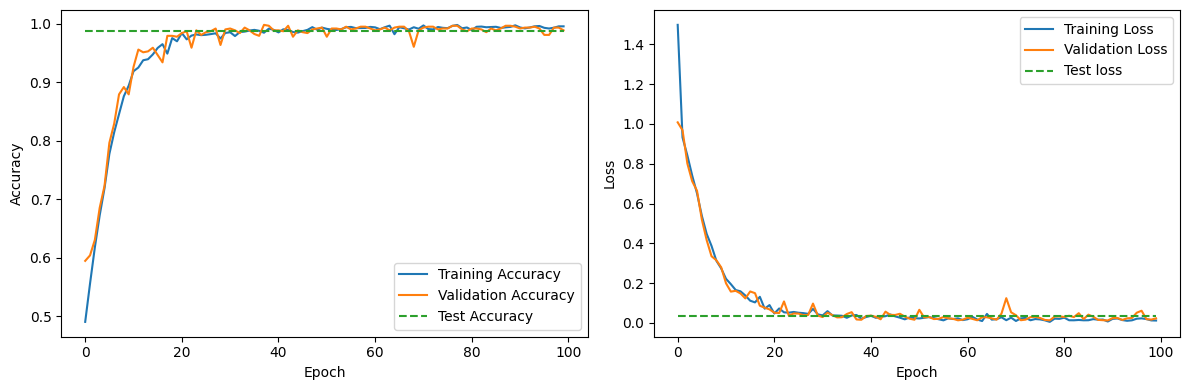

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.plot([0, len(hist.history['accuracy'])-1], [test_acc, test_acc], '--', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.plot([0, len(hist.history['loss'])-1], [test_loss, test_loss], '--', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Get the results of the hyperparameter tuning
results = tuner.results_summary()

if results is not None:
    # Extract the relevant data from the results
    columns = ['val_loss', 'val_accuracy', 'loss', 'accuracy', 'conv1_filters', 'conv2_filters', 'dropout_1', 'conv3_filters', 'dropout_2', 'dense_units_1', 'dense_units_2', 'learning_rate']
    data = []
    for row in results.split('\n')[3:-1]:
        data.append(row.split('\t')[1:])

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data, columns=columns, dtype=float)

    # Normalize the columns
    normalized_df = (df - df.min()) / (df.max() - df.min())

    # Add the target values to the normalized DataFrame
    normalized_df['target'] = normalized_df['val_loss'] + normalized_df['val_accuracy'] - normalized_df['loss'] - normalized_df['accuracy']

    # Sort the DataFrame by the target values
    normalized_df = normalized_df.sort_values('target', ascending=False)

    # Create the parallel coordinates chart
    plt.figure(figsize=(10, 6))
    pd.plotting.parallel_coordinates(normalized_df.head(10), 'target', colormap='cool')
    plt.legend(loc='best')
    plt.xlabel('Hyperparameters')
    plt.ylabel('Normalized Values')
    plt.title('Parallel Coordinates Chart')
    plt.show()
else:
    print("No results available.")


Results summary
Results in tuner/my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel: 5
conv2_filters: 32
conv2_kernel: 3
dropout: 0.2
dense1_units: 256
learning_rate: 0.001
Score: 0.012406839057803154

Trial 1 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel: 3
conv2_filters: 96
conv2_kernel: 3
dropout: 0.4
dense1_units: 64
learning_rate: 0.0001
Score: 0.04619947448372841

Trial 2 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 5
conv2_filters: 128
conv2_kernel: 5
dropout: 0.4
dense1_units: 64
learning_rate: 0.01
Score: 0.09756913036108017

Trial 0 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel: 5
conv2_filters: 64
conv2_kernel: 5
dropout: 0.4
dense1_units: 256
learning_rate: 0.01
Score: 1.032240867614746

Trial 3 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 5
conv2_filters: 32
conv2_kernel: 3
dropout: 0.2
dense1_units: 64
learning_rate: 0.01
Score: 1.0322519

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the results of the hyperparameter tuning
results = tuner.results_summary()

if results is not None:
    # Extract the relevant data from the results
    columns = ['val_loss', 'val_accuracy', 'loss', 'accuracy', 'conv1_filters', 'conv2_filters', 'dropout_1', 'conv3_filters', 'dropout_2', 'dense_units_1', 'dense_units_2', 'learning_rate']
    data = []
    for row in results.split('\n')[3:-1]:
        data.append(row.split('\t')[1:])

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data, columns=columns, dtype=float)

    # Normalize the columns
    normalized_df = (df - df.min()) / (df.max() - df.min())

    # Add the target values to the normalized DataFrame
    normalized_df['target'] = normalized_df['val_loss'] + normalized_df['val_accuracy'] - normalized_df['loss'] - normalized_df['accuracy']

    # Add test accuracy to the normalized DataFrame
    test_acc_list = [test_acc] * len(normalized_df)
    normalized_df['test_accuracy'] = test_acc_list

    # Sort the DataFrame by the target values
    normalized_df = normalized_df.sort_values('target', ascending=False)

    # Create the parallel coordinates chart
    plt.figure(figsize=(12, 8))
    pd.plotting.parallel_coordinates(normalized_df.head(10), 'target', colormap='cool')
    plt.legend(loc='best')
    plt.xlabel('Hyperparameters')
    plt.ylabel('Normalized Values')
    plt.title('Parallel Coordinates Chart with Test Accuracy')
    plt.show()
else:
    print("No results available.")


Results summary
Results in tuner/my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 4 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel: 5
conv2_filters: 32
conv2_kernel: 3
dropout: 0.2
dense1_units: 256
learning_rate: 0.001
Score: 0.012406839057803154

Trial 1 summary
Hyperparameters:
conv1_filters: 16
conv1_kernel: 3
conv2_filters: 96
conv2_kernel: 3
dropout: 0.4
dense1_units: 64
learning_rate: 0.0001
Score: 0.04619947448372841

Trial 2 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 5
conv2_filters: 128
conv2_kernel: 5
dropout: 0.4
dense1_units: 64
learning_rate: 0.01
Score: 0.09756913036108017

Trial 0 summary
Hyperparameters:
conv1_filters: 32
conv1_kernel: 5
conv2_filters: 64
conv2_kernel: 5
dropout: 0.4
dense1_units: 256
learning_rate: 0.01
Score: 1.032240867614746

Trial 3 summary
Hyperparameters:
conv1_filters: 64
conv1_kernel: 5
conv2_filters: 32
conv2_kernel: 3
dropout: 0.2
dense1_units: 64
learning_rate: 0.01
Score: 1.0322519

In [ ]:
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.7/214.7 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=d678f1cec6044f5eb17b34ff6df77893a252ae58003fb28cc43ad4161648d847
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
import wandb
import plotly.graph_objects as go
import pandas as pd

# Initialize wandb
wandb.init(project='my_project')

# Run hyperparameter tuning
tuner.search(train_ds,
             validation_data=val_ds,
             epochs=100,
             batch_size=64,
             verbose=1)

# Get the results of the hyperparameter tuning
results = tuner.results_summary()

if results is not None:
    # Extract the relevant data from the results
    columns = ['val_loss', 'val_accuracy', 'loss', 'accuracy']
    data = []
    for row in results.split('\n')[3:-1]:
        data.append(row.split('\t')[1:])

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data, columns=columns, dtype=float)

    # Add hyperparameters from wandb.config
    config_hyperparameters = ['conv1_filters', 'conv2_filters', 'dropout_1', 'conv3_filters', 'dropout_2', 'dense_units_1', 'dense_units_2', 'learning_rate']
    for hyperparameter in config_hyperparameters:
        df[hyperparameter] = wandb.config[hyperparameter]

    # Create the parallel coordinates chart
    fig = go.Figure(data=go.Parcoords(
        line=dict(color=df['val_loss'],
                  colorscale='Jet',
                  showscale=True,
                  reversescale=True),
        dimensions=list([
            dict(label='val_loss', values=df['val_loss']),
            dict(label='val_accuracy', values=df['val_accuracy']),
            dict(label='loss', values=df['loss']),
            dict(label='accuracy', values=df['accuracy']),
            dict(label='conv1_filters', values=df['conv1_filters']),
            dict(label='conv2_filters', values=df['conv2_filters']),
            dict(label='dropout_1', values=df['dropout_1']),
            dict(label='conv3_filters', values=df['conv3_filters']),
            dict(label='dropout_2', values=df['dropout_2']),
            dict(label='dense_units_1', values=df['dense_units_1']),
            dict(label='dense_units_2', values=df['dense_units_2']),
            dict(label='learning_rate', values=df['learning_rate'])
        ])
    ))

    fig.update_layout(
        title='Parallel Coordinates Chart',
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black')
    )

    fig.show()
else:
    print("No results available.")


Results summary
Results in tuner/my_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 128
dropout_1: 0.4
conv3_filters: 224
dropout_2: 0.5
dense_units_1: 160
dense_units_2: 32
learning_rate: 0.001
conv1_kernel: 3
conv2_kernel: 3
dropout: 0.2
dense1_units: 64
Score: 0.0016929465346038342

Trial 4 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 48
dropout_1: 0.5
conv3_filters: 160
dropout_2: 0.5
dense_units_1: 64
dense_units_2: 64
learning_rate: 0.0001
conv1_kernel: 5
conv2_kernel: 5
dropout: 0.2
dense1_units: 256
Score: 0.007927676662802696

Trial 1 summary
Hyperparameters:
conv1_filters: 80
conv2_filters: 96
dropout_1: 0.2
conv3_filters: 192
dropout_2: 0.5
dense_units_1: 96
dense_units_2: 128
learning_rate: 0.0001
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and